In [1]:
# before running the noteboook, need to run this kenerl first
%env MKL_THREADING_LAYER=SEQUENTIAL
%env OMP_NUM_THREADS=1
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1


env: MKL_THREADING_LAYER=SEQUENTIAL
env: OMP_NUM_THREADS=1
env: MKL_NUM_THREADS=1
env: NUMEXPR_NUM_THREADS=1


# 1.Import Package

In [2]:
import numpy as np
from dataclasses import dataclass
from typing import List
import random
import scipy.optimize as opt
import scipy.linalg as sla


# 2. Data preprocessing function Definition

In [3]:
# load data
@dataclass
class Dataset:
    Xtr: np.ndarray  # noisy train+val feature
    Str: np.ndarray  # noisy train+val label
    Xts: np.ndarray  # clean test feature
    Yts: np.ndarray  # clean test label

def load_npz(path): 
    d=np.load(path); 
    return Dataset(d['Xtr'],d['Str'],d['Xts'],d['Yts'])

def set_seed(seed: int):
    np.random.seed(seed)
    random.seed(seed)

def one_hot(y: np.ndarray, C: int) -> np.ndarray:
    oh = np.zeros((y.shape[0], C), dtype=np.float32)
    oh[np.arange(y.shape[0]), y] = 1.0
    return oh

def softmax(z: np.ndarray) -> np.ndarray:
    z = z - z.max(axis=1, keepdims=True)       
    expz = np.exp(z)
    return expz / (expz.sum(axis=1, keepdims=True) + 1e-12)

def accuracy(y_true, y_pred):
    return float((y_true == y_pred).mean())

def split(X, y, ratio=0.2, seed=42):
    set_seed(seed)
    n = X.shape[0]
    idx = np.random.permutation(n)
    sp = int(n * (1 - ratio))
    return X[idx[:sp]], y[idx[:sp]], X[idx[sp:]], y[idx[sp:]]

In [4]:
def standardize_train_val(Xtr, Xva):
    Xtr = Xtr.astype(np.float32)
    Xva = Xva.astype(np.float32)
    if Xtr.max() > 1.5:
        Xtr /= 255.0
        Xva /= 255.0
    mu = Xtr.mean(axis=0, keepdims=True)
    sg = Xtr.std(axis=0, keepdims=True) + 1e-6
    Xtr = (Xtr - mu) / sg
    Xva = (Xva - mu) / sg
    return Xtr, Xva

# 3 Warmup Model  Classification

## 3.1 Softmax

In [5]:
class SoftmaxAnchor:
    def __init__(self, in_dim: int, num_classes: int, lr: float = 0.05, weight_decay: float = 5e-4):
        self.C = num_classes
        self.W = 0.01 * np.random.randn(in_dim, num_classes).astype(np.float32)
        self.b = np.zeros((num_classes,), dtype=np.float32)
        self.lr = lr
        self.wd = weight_decay

    def _forward(self, X):
        logits = X @ self.W + self.b
        return softmax(logits)

    def _loss_and_grads(self, X, y):
        N = X.shape[0]
        P = self._forward(X)
        loss = -np.log(P[np.arange(N), y] + 1e-12).mean()
        if self.wd > 0:
            loss += 0.5 * self.wd * np.sum(self.W * self.W)
        G = P
        G[np.arange(N), y] -= 1.0
        G /= N
        dW = X.T @ G + self.wd * self.W
        db = G.sum(axis=0)
        return loss, dW, db

    def fit(self, X, y, Xval=None, yval=None, epochs=10, batch_size=256, verbose=True, seed=0):
        set_seed(seed)
        N = X.shape[0]
        for ep in range(1, epochs + 1):
            idx = np.random.permutation(N)
            Xs, ys = X[idx], y[idx]
            for st in range(0, N, batch_size):
                ed = min(st + batch_size, N)
                loss, dW, db = self._loss_and_grads(Xs[st:ed], ys[st:ed])
                self.W -= self.lr * dW
                self.b -= self.lr * db
            if verbose:
                tr_acc = self.score(X, y)
                msg = f"[Softmax] epoch {ep:02d} | train_acc={tr_acc:.3f}"
                if Xval is not None:
                    va_acc = self.score(Xval, yval)
                    msg += f", val_acc={va_acc:.3f}"
                print(msg)

    def predict_proba(self, X):
        return self._forward(X)

    def predict(self, X):
        return np.argmax(self._forward(X), axis=1)

    def score(self, X, y):
        return accuracy(y, self.predict(X))


# 4 Transition Matrix Estimator

## 4.1 Anchor point Selection (Top a)

In [6]:
def select_anchors_topk(probs: np.ndarray, top_pct: float = 0.01):
    N, C = probs.shape
    k = max(1, int(np.ceil(top_pct * N)))
    anchors = []
    for i in range(C):
        idx = np.argsort(probs[:, i])[-k:]  
        anchors.append(idx)
    return anchors


## 4.2 Main Function (Estimate Transition Matrix T)

In [7]:
def estimate_T_anchor(probs: np.ndarray,
                      noisy_labels: np.ndarray,
                      anchors: list,
                      use_counts: bool = False,
                      eps: float = 1e-6) -> np.ndarray:

    N, C = probs.shape
    T_hat = np.zeros((C, C), dtype=np.float32)
    for i in range(C):
        idx = anchors[i]
        if len(idx) == 0:
            row = np.zeros(C, dtype=np.float32); row[i] = 1.0
        else:
            if use_counts:
                hist = np.bincount(noisy_labels[idx], minlength=C).astype(np.float32)
                row = hist / (hist.sum() + eps)
            else:
                row = probs[idx].mean(axis=0).astype(np.float32)
                row = row / (row.sum() + eps)
        row = np.clip(row, eps, 1.0)
        row = row / row.sum()
        T_hat[i] = row
    return T_hat

def estimate_T_from_probs(probs: np.ndarray,
                          noisy_labels: np.ndarray,
                          top_pct: float = 0.01,
                          use_counts: bool = False,
                          verbose: bool = True):

    assert probs.shape[0] == noisy_labels.shape[0], 
    C = probs.shape[1]

    anchors = select_anchors_topk(probs, top_pct=top_pct)
    if verbose:
        cnts = [len(a) for a in anchors]
        print(f"[Anchor] top_pct={top_pct:.4f}, per-class counts={cnts}")

    T_hat = estimate_T_anchor(probs, noisy_labels, anchors, use_counts=use_counts)

    if verbose:
        row_sums = T_hat.sum(axis=1)
        print("[T_hat] row sums:", np.round(row_sums, 6))
        def smart_round(x):
            s = f"{x:.4f}".rstrip('0').rstrip('.')
            return s if s != '' else '0'
        print("T_hat:\n",
              np.array2string(T_hat, formatter={'float_kind': smart_round}, separator=' '))

    return T_hat, anchors


# 5. Experiment

## 5.1 dataset classification performance

In [8]:
data1 = load_npz("datasets/FashionMNIST0.3.npz")
data2 = load_npz("datasets/FashionMNIST0.6.npz")
data3 = load_npz("datasets/CIFAR.npz")

Xtr_1, ytr_1, Xva_1, yva_1 = split(data1.Xtr, data1.Str, ratio=0.2, seed=0)
Xtr_1_std, Xva_1_std = standardize_train_val(Xtr_1, Xva_1)

Xtr_2, ytr_2, Xva_2, yva_2 = split(data2.Xtr, data2.Str, ratio=0.2, seed=0)
Xtr_2_std, Xva_2_std = standardize_train_val(Xtr_2, Xva_2)

Xtr_3, ytr_3, Xva_3, yva_3 = split(data3.Xtr, data3.Str, ratio=0.2, seed=0)
#flatten
Xtr_3 = Xtr_3.reshape(len(Xtr_3), -1)
Xva_3 = Xva_3.reshape(len(Xva_3), -1)

Xtr_3_std, Xva_3_std = standardize_train_val(Xtr_3, Xva_3)

in_dim_1=Xtr_1_std.shape[1]
in_dim_2=Xtr_2_std.shape[1]
in_dim_3=Xtr_3_std.shape[1]

### 5.1.1 dataset 1

In [9]:
import copy

anchor1 = SoftmaxAnchor(in_dim_1, num_classes=3, lr=0.02, weight_decay=5e-4)

best_train_acc = 0.0
best_val_acc = 0.0
best_epoch = 0
best_model = None

for epoch in range(40):
    anchor1.fit(Xtr_1_std, ytr_1, epochs=1, batch_size=512, verbose=False, seed=0)
    train_acc = anchor1.score(Xtr_1_std, ytr_1)
    val_acc = anchor1.score(Xva_1_std, yva_1)
    print(f"[Softmax] epoch {epoch+1:02d} | train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")

    if train_acc > best_train_acc:
        best_train_acc = train_acc
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model = copy.deepcopy(anchor1)

print("\n=== FashionMNIST0.3 ===")
print(f"Best epoch: {best_epoch}")
print(f"Best train acc: {best_train_acc:.4f}")
print(f"Val acc at best train acc: {best_val_acc:.4f}")
anchor1 = best_model

[Softmax] epoch 01 | train_acc=0.663, val_acc=0.667
[Softmax] epoch 02 | train_acc=0.667, val_acc=0.670
[Softmax] epoch 03 | train_acc=0.669, val_acc=0.671
[Softmax] epoch 04 | train_acc=0.670, val_acc=0.674
[Softmax] epoch 05 | train_acc=0.672, val_acc=0.672
[Softmax] epoch 06 | train_acc=0.673, val_acc=0.673
[Softmax] epoch 07 | train_acc=0.673, val_acc=0.674
[Softmax] epoch 08 | train_acc=0.674, val_acc=0.672
[Softmax] epoch 09 | train_acc=0.674, val_acc=0.673
[Softmax] epoch 10 | train_acc=0.676, val_acc=0.674
[Softmax] epoch 11 | train_acc=0.676, val_acc=0.674
[Softmax] epoch 12 | train_acc=0.676, val_acc=0.674
[Softmax] epoch 13 | train_acc=0.676, val_acc=0.675
[Softmax] epoch 14 | train_acc=0.675, val_acc=0.675
[Softmax] epoch 15 | train_acc=0.675, val_acc=0.674
[Softmax] epoch 16 | train_acc=0.676, val_acc=0.674
[Softmax] epoch 17 | train_acc=0.676, val_acc=0.672
[Softmax] epoch 18 | train_acc=0.677, val_acc=0.671
[Softmax] epoch 19 | train_acc=0.678, val_acc=0.670
[Softmax] ep

### 5.1.2 dataset 2

In [10]:
anchor2 = SoftmaxAnchor(in_dim_2, num_classes=3, lr=0.02, weight_decay=5e-4)

best_train_acc = 0.0
best_val_acc = 0.0
best_epoch = 0
best_model = None

for epoch in range(40):
    anchor2.fit(Xtr_2_std, ytr_2, epochs=1, batch_size=512, verbose=False, seed=0)
    train_acc = anchor2.score(Xtr_2_std, ytr_2)
    val_acc = anchor2.score(Xva_2_std, yva_2)
    print(f"[Softmax] epoch {epoch+1:02d} | train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")

    if train_acc > best_train_acc:
        best_train_acc = train_acc
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model = copy.deepcopy(anchor2)

print("\n=== FashionMNIST0.6 ===")
print(f"Best epoch: {best_epoch}")
print(f"Best train acc: {best_train_acc:.4f}")
print(f"Val acc at best train acc: {best_val_acc:.4f}")
anchor2 = best_model

[Softmax] epoch 01 | train_acc=0.374, val_acc=0.362
[Softmax] epoch 02 | train_acc=0.378, val_acc=0.361
[Softmax] epoch 03 | train_acc=0.382, val_acc=0.359
[Softmax] epoch 04 | train_acc=0.385, val_acc=0.359
[Softmax] epoch 05 | train_acc=0.387, val_acc=0.358
[Softmax] epoch 06 | train_acc=0.387, val_acc=0.358
[Softmax] epoch 07 | train_acc=0.387, val_acc=0.359
[Softmax] epoch 08 | train_acc=0.388, val_acc=0.361
[Softmax] epoch 09 | train_acc=0.390, val_acc=0.360
[Softmax] epoch 10 | train_acc=0.391, val_acc=0.359
[Softmax] epoch 11 | train_acc=0.393, val_acc=0.361
[Softmax] epoch 12 | train_acc=0.394, val_acc=0.360
[Softmax] epoch 13 | train_acc=0.394, val_acc=0.359
[Softmax] epoch 14 | train_acc=0.395, val_acc=0.359
[Softmax] epoch 15 | train_acc=0.396, val_acc=0.359
[Softmax] epoch 16 | train_acc=0.396, val_acc=0.359
[Softmax] epoch 17 | train_acc=0.397, val_acc=0.359
[Softmax] epoch 18 | train_acc=0.398, val_acc=0.358
[Softmax] epoch 19 | train_acc=0.399, val_acc=0.357
[Softmax] ep

### 5.1.3 Dataset 3

In [11]:
anchor3 = SoftmaxAnchor(in_dim_3, num_classes=3, lr=0.02, weight_decay=5e-4)

best_train_acc = 0.0
best_val_acc = 0.0
best_epoch = 0
best_model = None

for epoch in range(40):
    anchor3.fit(Xtr_3_std, ytr_3, epochs=1, batch_size=512, verbose=False, seed=0)
    train_acc = anchor3.score(Xtr_3_std, ytr_3)
    val_acc = anchor3.score(Xva_3_std, yva_3)
    print(f"[Softmax] epoch {epoch+1:02d} | train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")

    if train_acc > best_train_acc:
        best_train_acc = train_acc
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model = copy.deepcopy(anchor3)

print("\n=== CIFAR ===")
print(f"Best epoch: {best_epoch}")
print(f"Best train acc: {best_train_acc:.4f}")
print(f"Val acc at best train acc: {best_val_acc:.4f}")
anchor3 = best_model

[Softmax] epoch 01 | train_acc=0.319, val_acc=0.331
[Softmax] epoch 02 | train_acc=0.339, val_acc=0.342
[Softmax] epoch 03 | train_acc=0.340, val_acc=0.342
[Softmax] epoch 04 | train_acc=0.343, val_acc=0.343
[Softmax] epoch 05 | train_acc=0.347, val_acc=0.342
[Softmax] epoch 06 | train_acc=0.349, val_acc=0.343
[Softmax] epoch 07 | train_acc=0.350, val_acc=0.341
[Softmax] epoch 08 | train_acc=0.352, val_acc=0.340
[Softmax] epoch 09 | train_acc=0.354, val_acc=0.341
[Softmax] epoch 10 | train_acc=0.353, val_acc=0.341
[Softmax] epoch 11 | train_acc=0.365, val_acc=0.358
[Softmax] epoch 12 | train_acc=0.366, val_acc=0.358
[Softmax] epoch 13 | train_acc=0.369, val_acc=0.360
[Softmax] epoch 14 | train_acc=0.373, val_acc=0.360
[Softmax] epoch 15 | train_acc=0.376, val_acc=0.360
[Softmax] epoch 16 | train_acc=0.378, val_acc=0.358
[Softmax] epoch 17 | train_acc=0.382, val_acc=0.353
[Softmax] epoch 18 | train_acc=0.383, val_acc=0.353
[Softmax] epoch 19 | train_acc=0.370, val_acc=0.346
[Softmax] ep

## 5.2 Compare the Estimated T with True T on first two dataset

In [12]:
import numpy as np

def evaluate_T(T_hat: np.ndarray, T_true: np.ndarray, verbose: bool = True):
    
    assert T_hat.shape == T_true.shape, "T_hat.shape != T_true"
    diff = T_hat - T_true

    per_row_L1 = np.sum(np.abs(diff), axis=1)

    frob = np.linalg.norm(diff, 'fro')

    max_abs = np.max(np.abs(diff))

    if verbose:
        print("T_hat:\n", np.round(T_hat, 4))
        print("T_true:\n", np.round(T_true, 4))
        print("-" * 30)
        print("per row L1:", np.round(per_row_L1, 4))
        print("Frobenius:", round(float(frob), 4))
        print("max|Δ|:", round(float(max_abs), 4))

    return {
        "per_row_L1": per_row_L1,
        "frobenius": frob,
        "max_abs": max_abs
    }


In [13]:
T_true_03 = np.array([[0.7, 0.3, 0.0],
                      [0.0, 0.7, 0.3],
                      [0.3, 0.0, 0.7]], dtype=np.float32)

T_true_06 = np.array([[0.4, 0.3, 0.3],
                      [0.3, 0.4, 0.3],
                      [0.3, 0.3, 0.4]], dtype=np.float32)



### 5.2.1 dataset 1

α=0.10 | Frobenius=0.1762 | max|Δ|=0.0993
α=0.20 | Frobenius=0.0957 | max|Δ|=0.0594
α=0.22 | Frobenius=0.0822 | max|Δ|=0.0528
α=0.25 | Frobenius=0.0717 | max|Δ|=0.0506
α=0.28 | Frobenius=0.0650 | max|Δ|=0.0439
α=0.30 | Frobenius=0.0708 | max|Δ|=0.0447
α=0.35 | Frobenius=0.1332 | max|Δ|=0.0714


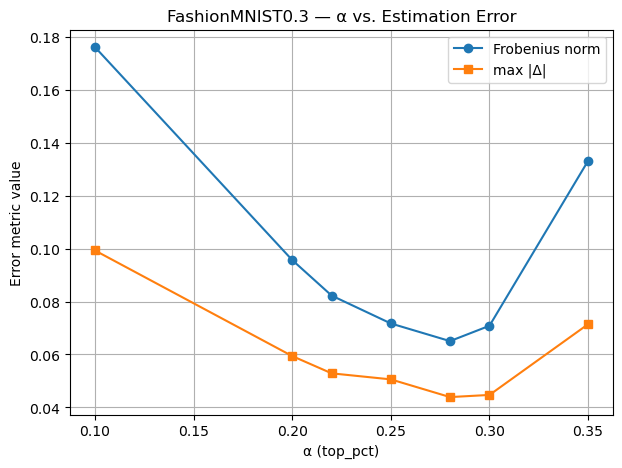

In [14]:
import matplotlib.pyplot as plt

alphas = [0.1, 0.2, 0.22, 0.25, 0.28, 0.3,0.35]
frob_list, maxabs_list = [], []

P_1 = anchor1.predict_proba(Xtr_1_std)

for a in alphas:
    T_hat_1, _ = estimate_T_from_probs(P_1, ytr_1, top_pct=a, use_counts=True, verbose=False)
    diff = T_hat_1 - T_true_03
    frob = np.linalg.norm(diff, 'fro')
    max_abs = np.max(np.abs(diff))
    frob_list.append(frob)
    maxabs_list.append(max_abs)
    print(f"α={a:.2f} | Frobenius={frob:.4f} | max|Δ|={max_abs:.4f}")
plt.figure(figsize=(7, 5))
plt.plot(alphas, frob_list, marker='o', label='Frobenius norm')
plt.plot(alphas, maxabs_list, marker='s', label='max |Δ|')
plt.xlabel("α (top_pct)")
plt.ylabel("Error metric value")
plt.title("FashionMNIST0.3 — α vs. Estimation Error")
plt.legend()
plt.grid(True)
plt.show()


### 5.2.2 dataset 2

α=0.10 | Frobenius=0.1977 | max|Δ|=0.1326
α=0.20 | Frobenius=0.1192 | max|Δ|=0.0861
α=0.30 | Frobenius=0.0722 | max|Δ|=0.0528
α=0.35 | Frobenius=0.0524 | max|Δ|=0.0373
α=0.38 | Frobenius=0.0451 | max|Δ|=0.0283
α=0.40 | Frobenius=0.0429 | max|Δ|=0.0252
α=0.42 | Frobenius=0.0425 | max|Δ|=0.0230
α=0.45 | Frobenius=0.0467 | max|Δ|=0.0265
α=0.48 | Frobenius=0.0470 | max|Δ|=0.0262
α=0.50 | Frobenius=0.0476 | max|Δ|=0.0262
α=0.60 | Frobenius=0.0621 | max|Δ|=0.0343


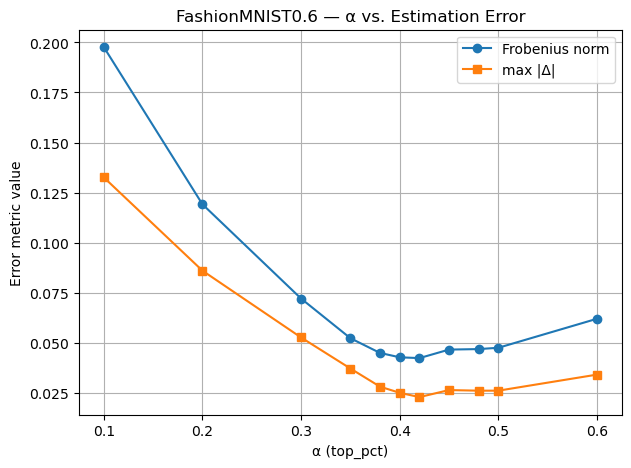

In [22]:
alphas = [0.1,0.2,0.3,0.35,0.38,0.4,0.42,0.45,0.48,0.5,0.6]
frob_list, maxabs_list = [], []

P_2 = anchor2.predict_proba(Xtr_2_std)

for a in alphas:
    T_hat_2, _ = estimate_T_from_probs(P_2, ytr_2, top_pct=a, use_counts=True, verbose=False)
    diff = T_hat_2 - T_true_06
    frob = np.linalg.norm(diff, 'fro')
    max_abs = np.max(np.abs(diff))
    frob_list.append(frob)
    maxabs_list.append(max_abs)
    print(f"α={a:.2f} | Frobenius={frob:.4f} | max|Δ|={max_abs:.4f}")

# ---------- 可视化 ----------
plt.figure(figsize=(7, 5))
plt.plot(alphas, frob_list, marker='o', label='Frobenius norm')
plt.plot(alphas, maxabs_list, marker='s', label='max |Δ|')
plt.xlabel("α (top_pct)")
plt.ylabel("Error metric value")
plt.title("FashionMNIST0.6 — α vs. Estimation Error")
plt.legend()
plt.grid(True)
plt.show()

## 5.3 Estimate T for the dataset with Unknown Flip Rate

In [ ]:
print("!!( CIFAR )!!\n")

P_3 = anchor3.predict_proba(Xtr_3_std)  # (N, C)
T_list = []

for a in [0.4,0.42,0.45,0.48,0.5]:
    T_hat_3, _ = estimate_T_from_probs(P_3, ytr_3, top_pct=a, use_counts=True, verbose=False)
    T_list.append(T_hat_3)
    print(f"Softmax+Counts α={a}:")
    print(np.round(T_hat_3, 4))
    print()

T_mean = np.mean(T_list, axis=0)

print("=== MEAN RESULT ===")
print(np.round(T_mean, 4))
